In [1]:
### Computer Vision Application (classification via deep cnn)
###
### Nick Gammal

This code was modified from https://www.tensorflow.org/tutorials/images/transfer_learning

In [2]:
# imports

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import pathlib

data_dir = pathlib.Path("Rice_Image_Dataset").with_suffix('')


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/traitlets/config/application.py", line 1041, in launch_instance
    app.start()
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ipyk

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/traitlets/config/application.py", line 1041, in launch_instance
    app.start()
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ipyk

AttributeError: _ARRAY_API not found

# Data Prep

In [9]:
# set up train/validation split

batch_size = 32
img_height = 250
img_width = 250

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split = 0.2,
  subset = "training",
  seed = 7,
  image_size = (img_height, img_width),
  batch_size = batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split = 0.2,
  subset = "validation",
  seed = 7,
  image_size = (img_height, img_width),
  batch_size = batch_size)

Found 75000 files belonging to 5 classes.
Using 60000 files for training.
Found 75000 files belonging to 5 classes.
Using 15000 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']


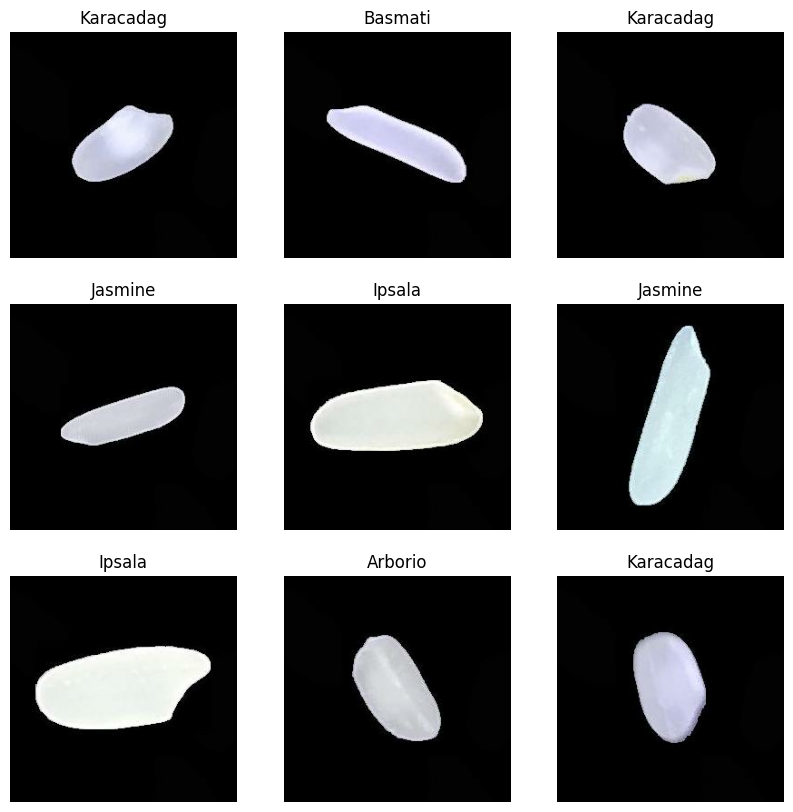

In [11]:
# visualize the rice

import matplotlib.pyplot as plt

plt.figure(figsize = (10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


# Modeling Prep

In [12]:
# training support

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
# build and compile model

normalize = layers.Rescaling(1./127.5, offset=-1)

base_model = keras.applications.EfficientNetV2B1(
    include_top = False,
    weights = "imagenet",
    input_shape = (250, 250, 3,)
)
base_model.trainable = False

global_average_layer = layers.GlobalAveragePooling2D()

prediction_layer = layers.Dense(len(class_names), activation = 'softmax')

inputs = keras.Input(shape = (250, 250, 3))
x = normalize(inputs)
x = base_model(x, training = False)
x = global_average_layer(x)
outputs = prediction_layer(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer = "adam",
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 250, 250, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_6 (Rescaling)         │ (None, 250, 250, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b1 (Functional)  │ (None, 8, 8, 1280)     │     6,931,124 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,937,529 (26.46 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 6,931,124 (26.44 MB)

# Initial Training

In [17]:

epochs = 20

history = model.fit(
  train_ds,
  validation_data = val_ds,
  epochs = epochs
)

Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 703s 2s/step - accuracy: 0.5179 - loss: 1.2147 - val_accuracy: 0.7664 - val_loss: 0.7931
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 711s 2s/step - accuracy: 0.6903 - loss: 0.8460 - val_accuracy: 0.8225 - val_loss: 0.6880
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 715s 2s/step - accuracy: 0.7268 - loss: 0.7594 - val_accuracy: 0.7923 - val_loss: 0.6210
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 718s 2s/step - accuracy: 0.7429 - loss: 0.7119 - val_accuracy: 0.8239 - val_loss: 0.5788
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 710s 2s/step - accuracy: 0.7612 - loss: 0.6712 - val_accuracy: 0.7665 - val_loss: 0.5563
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 708s 2s/step - accuracy: 0.7690 - loss: 0.6390 - val_accuracy: 0.8433 - val_loss: 0.5188
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 713s 2s/step - accuracy: 0.7810 - loss: 0.6193 - val_accuracy: 0.8642 - val_loss: 0.4982
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 707s 2s/step - accuracy: 0.7901 - loss: 0.5962 - val_accu

In [30]:
# retrieve epoch number with best validation performance

best_epoch = 1 + np.argmax(history.history['val_accuracy'])

print("Best Epoch:   " + str(best_epoch))
print("Best Performance:   " + str(max(history.history['val_accuracy'])))

Best Epoch:   20
Best Performance:   0.8948666453361511


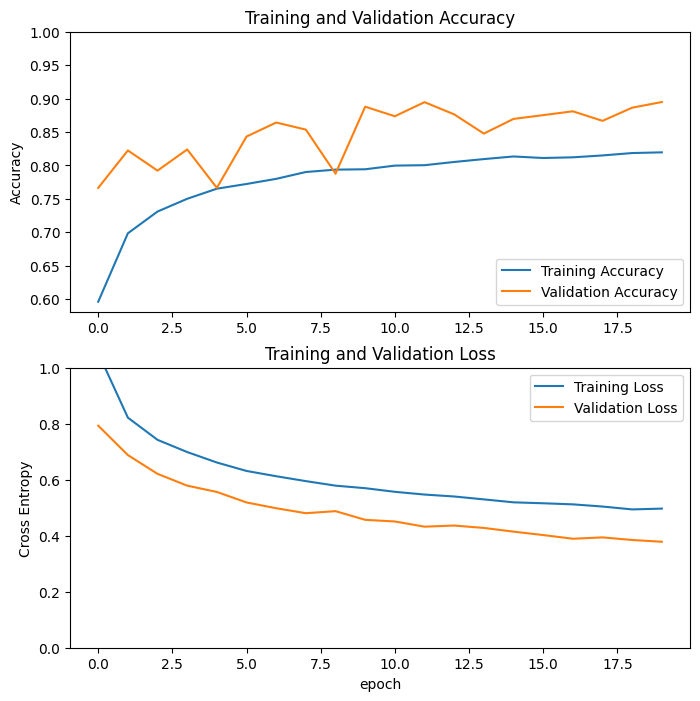

In [31]:
# Preliminary L

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize = (8, 8))
plt.subplot(2, 1, 1)
plt.plot(train_acc, label = 'Training Accuracy')
plt.plot(val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(train_loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Fine-Tuning

In [32]:
# un-freeze the last part of the base model 

base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = round(0.85 * len(base_model.layers))   # only fine-tune the last 15% of the base model

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [33]:
# recompile thawed (lol) model with smaller learning rate

model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = keras.optimizers.Adam(learning_rate = 0.0005),   # cut the learning rate in half
              metrics=['accuracy'])

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 250, 250, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_6 (Rescaling)         │ (None, 250, 250, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b1 (Functional)  │ (None, 8, 8, 1280)     │     6,931,124 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,937,529 (26.46 MB)

 Trainable params: 1,963,285 (7.49 MB)

 Non-trainable params: 4,974,244 (18.98 MB)

In [36]:
fine_tune_epochs = 10
total_epochs =  epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs = total_epochs,
                         initial_epoch = best_epoch,
                         validation_data = val_ds)

Epoch 21/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 850s 2s/step - accuracy: 0.8002 - loss: 0.5383 - val_accuracy: 0.9127 - val_loss: 0.2195
Epoch 22/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 844s 2s/step - accuracy: 0.9113 - loss: 0.2245 - val_accuracy: 0.9638 - val_loss: 0.0990
Epoch 23/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 875s 2s/step - accuracy: 0.9396 - loss: 0.1593 - val_accuracy: 0.9707 - val_loss: 0.0911
Epoch 24/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 943s 3s/step - accuracy: 0.9459 - loss: 0.1417 - val_accuracy: 0.9709 - val_loss: 0.0818
Epoch 25/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 899s 2s/step - accuracy: 0.9551 - loss: 0.1215 - val_accuracy: 0.9765 - val_loss: 0.0671
Epoch 26/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 841s 2s/step - accuracy: 0.9596 - loss: 0.1130 - val_accuracy: 0.9780 - val_loss: 0.0631
Epoch 27/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 847s 2s/step - accuracy: 0.9586 - loss: 0.1107 - val_accuracy: 0.9730 - val_loss: 0.0768
Epoch 28/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 860s 2s/step - accuracy: 0.9618 - loss: 0.1047 - 

# Final Model Performance

In [37]:
# combine training histories

training_accuracy = train_acc[:best_epoch] + history_fine.history['accuracy']
validation_accuracy = val_acc[:best_epoch] + history_fine.history['val_accuracy']

training_loss = train_loss[:best_epoch] + history_fine.history['loss']
validation_loss = val_loss[:best_epoch] + history_fine.history['val_loss']

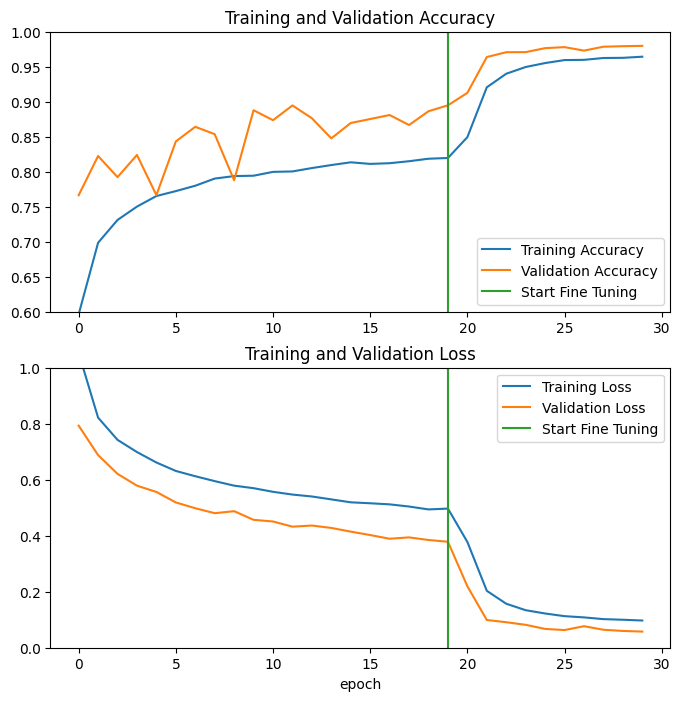

In [39]:
# visualize the learning curves together

plt.figure(figsize = (8, 8))
plt.subplot(2, 1, 1)
plt.plot(training_accuracy, label = 'Training Accuracy')
plt.plot(validation_accuracy, label = 'Validation Accuracy')
plt.ylim([0.6, 1])
plt.plot([best_epoch - 1, best_epoch - 1],
          plt.ylim(), label = 'Start Fine Tuning')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(training_loss, label = 'Training Loss')
plt.plot(validation_loss, label = 'Validation Loss')
plt.ylim([0, 1.0])
plt.plot([best_epoch - 1, best_epoch - 1],
         plt.ylim(), label = 'Start Fine Tuning')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [41]:
# retrieve model with best validation performance

best_model_index = np.argmax(validation_accuracy)

print("Best Epoch:   " + str(best_model_index + 1))
print("Best Performance:   " + str(max(validation_accuracy)))

Best Epoch:   30
Best Performance:   0.9797999858856201


In [42]:
# save the final model

model.save('best_model.keras')

## Data Citation

Koklu, M., Cinar, I., & Taspinar, Y. S. (2021). Classification of rice varieties with deep learning methods. Computers and Electronics in Agriculture, 187, 106285. https://doi.org/10.1016/j.compag.2021.106285

Cinar, I., & Koklu, M. (2021). Determination of Effective and Specific Physical Features of Rice Varieties by Computer Vision In Exterior Quality Inspection. Selcuk Journal of Agriculture and Food Sciences, 35(3), 229-243. https://doi.org/10.15316/SJAFS.2021.252

Cinar, I., & Koklu, M. (2022). Identification of Rice Varieties Using Machine Learning Algorithms. Journal of Agricultural Sciences https://doi.org/10.15832/ankutbd.862482

Cinar, I., & Koklu, M. (2019). Classification of Rice Varieties Using Artificial Intelligence Methods. International Journal of Intelligent Systems and Applications in Engineering, 7(3), 188-194. https://doi.org/10.18201/ijisae.2019355381

DATASET: https://www.muratkoklu.com/datasets/